<a href="https://colab.research.google.com/github/fraison/HNN/blob/master/LearningHamiltonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First: Make sure GPUs are enabled in this notebook from Edit->Notebook Settings.

# Here we use a Hamiltonian NN to predict the trajectory of a particle

In [14]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

In [15]:
n_coordinates = 2
hidden = 400

# Let's set up a simulation of a 2D falling ball, launched at a random speed:

In [16]:
N = 3000
p0 = np.random.rand(N, 2)
v0 = np.random.rand(N, 2)

In [17]:
p0[0]


array([0.41395783, 0.87492924])

In [18]:
p = []
v = []
T = 300

cp = p0
cv = v0
for _ in range(T):
  cp = cp + cv*0.01
  cv = cv + 0.01*(-9.81)*np.array([0, 1])[np.newaxis, :]

  p.append(cp)
  v.append(cv)

p = np.array(p).transpose(1, 0, 2)
v = np.array(v).transpose(1, 0, 2)

In [19]:
p.shape

(3000, 300, 2)

# Here's a bunch of trajectories with random initial conditions:

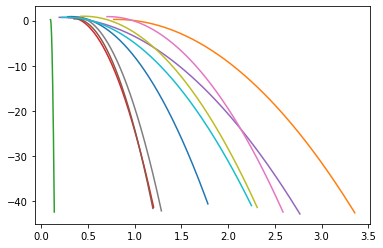

In [7]:
for i in range(10):
  plt.plot(p[i, :, 0], p[i, :, 1])

In [21]:
from torch.utils.data import DataLoader, TensorDataset

# Let's take the derivative of the neural network to use as our parameter updates:

In [22]:
tp = torch.from_numpy(p.astype(np.float32)).cuda()
tv = torch.from_numpy(v.astype(np.float32)).cuda()


#Arrange into [v0, v1, x0, x1]
X = torch.cat((tp[:, :-1], tv[:, :-1]), dim=2)[..., [2, 3, 0, 1]]
y = torch.cat((tp[:, 1:], tv[:, 1:]), dim=2)[..., [2, 3, 0, 1]]

M = torch.eye(n_coordinates*2).cuda()
M = torch.cat([M[n_coordinates:], -M[:n_coordinates]])
print(str(M))

# Base model (calculates H)
act = nn.Softplus
model = nn.Sequential(
    nn.Linear(n_coordinates*2, hidden), act(),
    nn.Linear(hidden, hidden), act(),
    nn.Linear(hidden, hidden), act(),
    nn.Linear(hidden, 1)
).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
print(str(model.parameters))
# Differentiates H and returns the derivatives of the canonical variables:
def canonical_model(cX):
  cX = torch.autograd.Variable(cX, requires_grad=True)
  # The final matrix multiply (@) here simply moves dH/dx to pdot, and dH/dp to xdot.
  return torch.autograd.grad(model(cX).sum(), cX, create_graph=True)[0] @ M.t()

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-1., -0., -0., -0.],
        [-0., -1., -0., -0.]], device='cuda:0')
<bound method Module.parameters of Sequential(
  (0): Linear(in_features=4, out_features=400, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=400, out_features=1, bias=True)
)>


# Here we set up our dataset to train on :

In [51]:
trainset = TensorDataset(X[:N*3//4*300].reshape(-1, 4), y[:N*3//4*300].reshape(-1, 4))
testset = TensorDataset(X[N*3//4*300:].reshape(-1, 4), y[N*3//4*300:].reshape(-1, 4))
train = DataLoader(trainset, shuffle=True, batch_size=512)
test = DataLoader(testset, shuffle=False, batch_size=512)

In [24]:
loss_fn = nn.MSELoss()



In [25]:
for _ in range(10):
  all_loss = 0.0
  for (cX, cy) in train:
    test_y = canonical_model(cX)
    loss = loss_fn(test_y, cy-cX)
    loss.backward()
    opt.step()
    opt.zero_grad()
    all_loss += loss.item()*512

  print(all_loss/len(trainset))

3.073237637277104e-05
3.050092059387327e-07
2.649890986439142e-07
2.539845538667132e-07
2.255563012840258e-07
1.9774667286533598e-07
1.768705462144799e-07
1.6657012783290992e-07
1.5248667212213398e-07
1.4196098601379074e-07


Here we can look at the prediction:

In [26]:
for (cX, cy) in test:
  test_y = canonical_model(cX)
  break


In [27]:
test_y, cy - cX

(tensor([[-1.8186e-04, -9.7249e-02,  7.0780e-03, -2.5414e-01],
         [-2.0863e-05, -9.7764e-02,  9.3496e-03, -9.0006e-02],
         [-4.0927e-05, -9.7759e-02,  2.4727e-04, -1.4475e-01],
         ...,
         [-2.4477e-05, -9.7743e-02,  7.0114e-03, -5.3907e-02],
         [-1.9828e-04, -9.7468e-02,  9.4023e-03, -2.4692e-01],
         [-4.2857e-05, -9.7829e-02,  8.4551e-03, -7.7036e-02]], device='cuda:0',
        grad_fn=<MmBackward>),
 tensor([[ 0.0000e+00, -9.8101e-02,  7.3617e-03, -2.5644e-01],
         [ 0.0000e+00, -9.8101e-02,  9.2757e-03, -9.0860e-02],
         [ 0.0000e+00, -9.8100e-02,  2.1893e-04, -1.4599e-01],
         ...,
         [ 0.0000e+00, -9.8100e-02,  6.9170e-03, -5.4635e-02],
         [ 0.0000e+00, -9.8099e-02,  9.6478e-03, -2.4870e-01],
         [ 0.0000e+00, -9.8100e-02,  8.4169e-03, -7.7785e-02]], device='cuda:0'))

# As we can see, the Hamiltonian NN has very closely learned the dynamics with very little training

# Homework problems:
0. Plot the resultant trajectories of a HNN.
1. Plot H over the relevant parameter space. Create a vector field showing its predicted path.
2. Write an RK4 method for this neural network.

In [32]:
cy.shape



torch.Size([488, 4])

In [70]:
test.dataset.tensors


TypeError: ignored

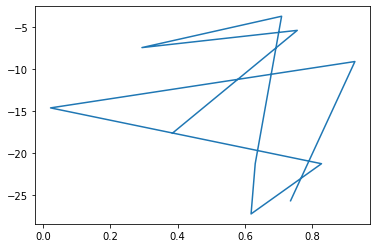

In [42]:
mycy=cy.cpu()
mycx = cX.cpu()




plt.plot(mycx[:10, 0], mycx[:10, 1])